In [3]:
import requests
from bs4 import BeautifulSoup as bs
import re
import pandas as pd
from google_trans_new import google_translator  
translator = google_translator()  

class HLN():
    def __init__(self):
        self.session = requests.Session()
        self.url = 'https://www.hln.be/net-binnen'
        self.data = []
        
    def parse(self):
        response = self.session.get(self.url)
        pattern = "(?<=window.location.href = ')[^']*"
        link = re.search(pattern, response.text)[0]

        response = self.session.get(link)

        soup = bs(response.text, 'lxml')
        articles = soup.find('ul', class_='results__list').findAll('article')
        
        for article in articles[0:20]:
            category_name = article.find('span', class_='label label--plain').text
            self.get_article(article.find('a')['href'], category_name)  
        df = pd.DataFrame(self.data, columns=['category', 'title', 'article_intro', 'article_body','By','source'])
        df.to_csv('hln.csv',mode="a", index=False)
        
    def get_article(self, link, category_name):
        print(link)
        response = self.session.get(link)
        soup = bs(response.text, 'lxml')
        
        try:
            try:
                by = soup.find("span",class_= "article__source").text.strip()
                print(f"By : {by}")
            except:
                by = ""
            try:
                source = soup.find("span",class_="article__credit-source").text.strip()
                print(f"Source : {source}")
            except:
                source = ""
            title = soup.find('h1', class_='article__title').text
            title = translator.translate(title,lang_src='nl',lang_tgt='en')
            article_intro = soup.find('p', class_='article__intro').text.strip()
            article_intro = translator.translate(article_intro,lang_src='nl',lang_tgt='en')
            article_body = ' '.join(translator.translate(p.text.strip()) for p in soup.find('div', class_='article__body').findAll('p')) 
            self.data.append([category_name, title, article_intro, article_body,by,source])
        except Exception as e:
            print(e)
            pass

In [4]:
hln = HLN()
hln.parse()

https://www.hln.be/weernieuws/frisse-start-van-de-dag-met-later-stapelwolken-en-kans-op-buien~a7bd28b8/
By : AW
Source : Belga
https://www.hln.be/cercle-brugge/vanderhaeghe-was-de-missing-link-vijf-redenen-waarom-cercle-brugge-zich-weer-eens-kon-redden~af632794/
By : Tomas Taecke
https://www.hln.be/binnenland/overzicht-daling-nieuwe-gevallen-en-hospitalisaties-zet-zich-door-fors-meer-overlijdens~a61d07bc/
By : KVDS
https://www.hln.be/tv/bijzonder-loopwedstrijdje-met-kamal-kharmach-in-laatste-aflevering-van-de-klas~a8259514/
By : Jacob De Bruyne
https://www.hln.be/showbizz/braam-verreth-keert-terug-als-simon-in-familie-meteen-na-mijn-vertrek-polsten-ze-al-of-ik-wilde-terugkeren~a075f852/
By : Hans Luyten
Source : Dag Allemaal
https://www.hln.be/showbizz/annemie-de-jeugdliefde-van-kurt-rogiers-we-schreven-tot-drie-brieven-per-dag-soms-licht-erotisch~a48e8b07/
By : Jacob De Bruyne
https://www.hln.be/buitenland/ook-vlaamse-wijnbouwers-vechten-tegen-de-vorst-in-frankrijk-het-lijkt-romantisc

## Load Data From CSV

In [ ]:
import pandas as pd
import numpy as np
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
  
#the stemmer requires a language parameter 
snow_stemmer = SnowballStemmer(language='dutch') 
stop_words = set(stopwords.words('dutch')) 

In [ ]:
df = pd.read_csv('hln.csv')
df.head()

In [47]:
df.article_body = df.article_body.replace(np.nan, '')

In [48]:
df.shape

(170, 4)

In [49]:
df.drop_duplicates(keep=False, inplace=True)
df.reset_index(inplace = True, drop = True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   category       170 non-null    object
 1   title          170 non-null    object
 2   article_intro  170 non-null    object
 3   article_body   170 non-null    object
dtypes: object(4)
memory usage: 5.4+ KB


In [51]:
df['complete_article'] = df['title'].str.cat(df[['article_intro', 'article_body']], sep=' ')
df.head()

,category,title,article_intro,article_body,complete_article
0,Nieuws,LIVE. Frankrijk sluit de grenzen voor niet-ess...,Het wetenschappelijk comité van het Europees G...,"• Geen toffe vooruitzichten, wel onzekerheid: ...",LIVE. Frankrijk sluit de grenzen voor niet-ess...
1,Internet,Toezichtsraad Facebook vindt “verwijderbeleid”...,Een toezichtsraad van de sociale mediagigant F...,De raad geldt als een onafhankelijk controleli...,Toezichtsraad Facebook vindt “verwijderbeleid”...
2,Buitenland,Black Lives Matter-beweging genomineerd voor N...,De Black Lives Matter-beweging is dit jaar gen...,Eide is van mening dat dat BLM-beweging landen...,Black Lives Matter-beweging genomineerd voor N...
3,Belgisch Voetbal,Onze Antwerp-watcher over Lamkel Zé: “No way d...,AntwerpZe gaan hem houden. Maandag sluit de wi...,Gratis onbeperkt toegang tot Showbytes? Dat ka...,Onze Antwerp-watcher over Lamkel Zé: “No way d...
4,Jupiler Pro League,Lamkel Zé met twee goals belangrijk voor Antwe...,Jupiler Pro LeagueAntwerp heeft met de nodige ...,De thuisploeg nam meteen het initiatief tegen ...,Lamkel Zé met twee goals belangrijk voor Antwe...


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category          170 non-null    object
 1   title             170 non-null    object
 2   article_intro     170 non-null    object
 3   article_body      170 non-null    object
 4   complete_article  170 non-null    object
dtypes: object(5)
memory usage: 6.8+ KB


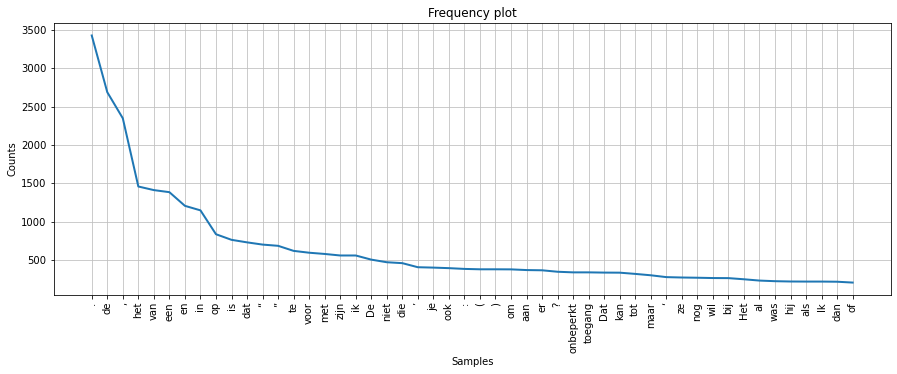

<AxesSubplot:title={'center':'Frequency plot'}, xlabel='Samples', ylabel='Counts'>

In [53]:
comment = ' '.join(df["complete_article"])
#function to split text into word
tokens = word_tokenize(comment)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)
plt.subplots(figsize=(15,5))
frequency_dist.plot(50,cumulative=False,title='Frequency plot')

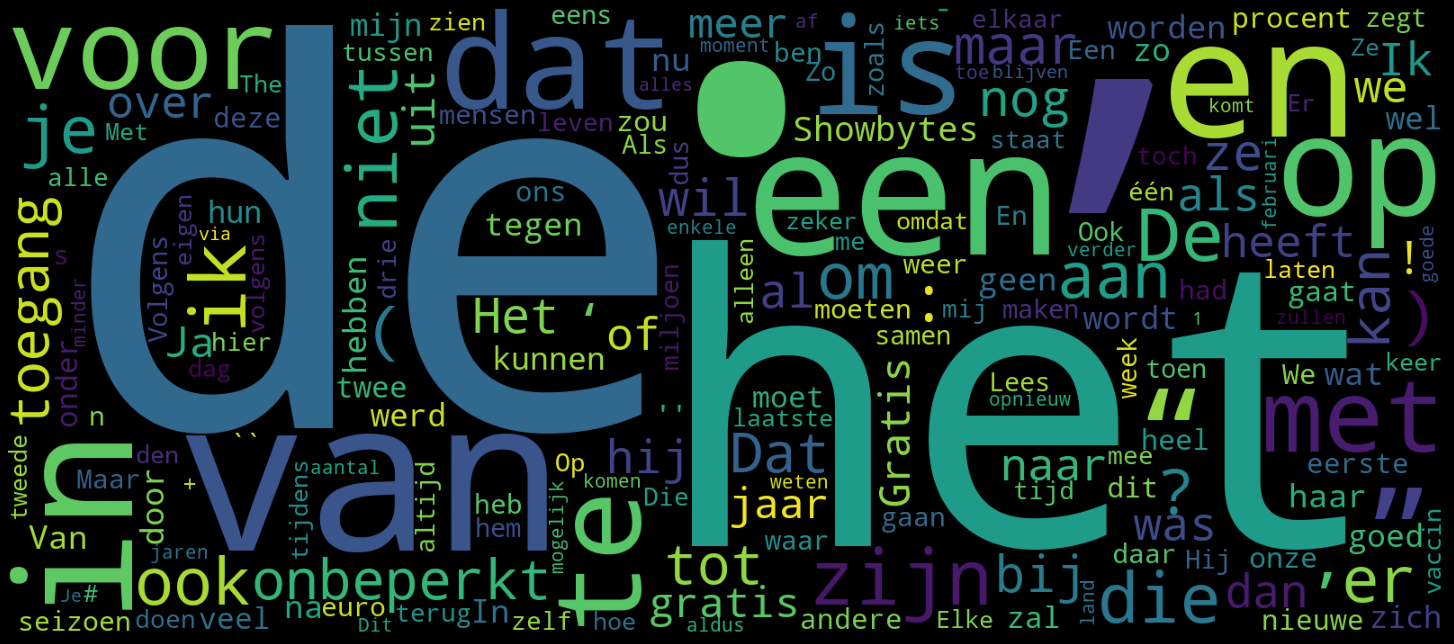

In [54]:
wordcloud = WordCloud(width=1600, height=700).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [55]:
def clean_text(text,replace=''):
    text = re.sub(r'\d+', '', str(text))
    text = text.lower() # lowercase text
    text = ' '.join(snow_stemmer.stem(word) for word in text.split() if word not in stop_words)
    text = text.translate(str.maketrans('', '', string.punctuation)) #remove punctuation characters
    text = "".join(i for i in text if ord(i) < 128) #remove non-ascii characters
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', replace, text) #removes URL from string
    return text

In [56]:
df['complete_article'] = df['complete_article'].apply(clean_text)
df.drop_duplicates(keep=False, inplace=True)
df.reset_index(inplace = True, drop = True)
df.head()

,category,title,article_intro,article_body,complete_article
0,Nieuws,LIVE. Frankrijk sluit de grenzen voor niet-ess...,Het wetenschappelijk comité van het Europees G...,"• Geen toffe vooruitzichten, wel onzekerheid: ...",live frankrijk sluit grenz nietessentieel reis...
1,Internet,Toezichtsraad Facebook vindt “verwijderbeleid”...,Een toezichtsraad van de sociale mediagigant F...,De raad geldt als een onafhankelijk controleli...,toezichtsrad facebok vindt verwijderbeleid fou...
2,Buitenland,Black Lives Matter-beweging genomineerd voor N...,De Black Lives Matter-beweging is dit jaar gen...,Eide is van mening dat dat BLM-beweging landen...,black lives matterbeweg genomineerd nobelprijs...
3,Belgisch Voetbal,Onze Antwerp-watcher over Lamkel Zé: “No way d...,AntwerpZe gaan hem houden. Maandag sluit de wi...,Gratis onbeperkt toegang tot Showbytes? Dat ka...,onz antwerpwatcher lamkel ze no way vercauter ...
4,Jupiler Pro League,Lamkel Zé met twee goals belangrijk voor Antwe...,Jupiler Pro LeagueAntwerp heeft met de nodige ...,De thuisploeg nam meteen het initiatief tegen ...,lamkel ze twee goal belangrijk antwerp zeg waa...


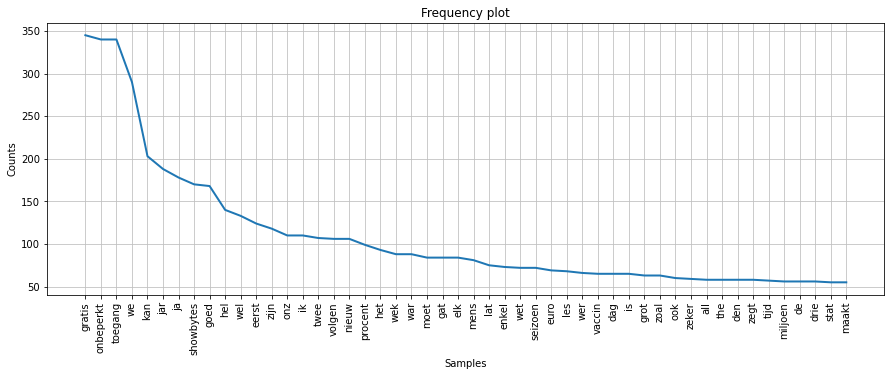

<AxesSubplot:title={'center':'Frequency plot'}, xlabel='Samples', ylabel='Counts'>

In [57]:
comment = ' '.join(df["complete_article"])
#function to split text into word
tokens = word_tokenize(comment)
vocabulary = set(tokens)
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)
plt.subplots(figsize=(15,5))
frequency_dist.plot(50,cumulative=False,title='Frequency plot')

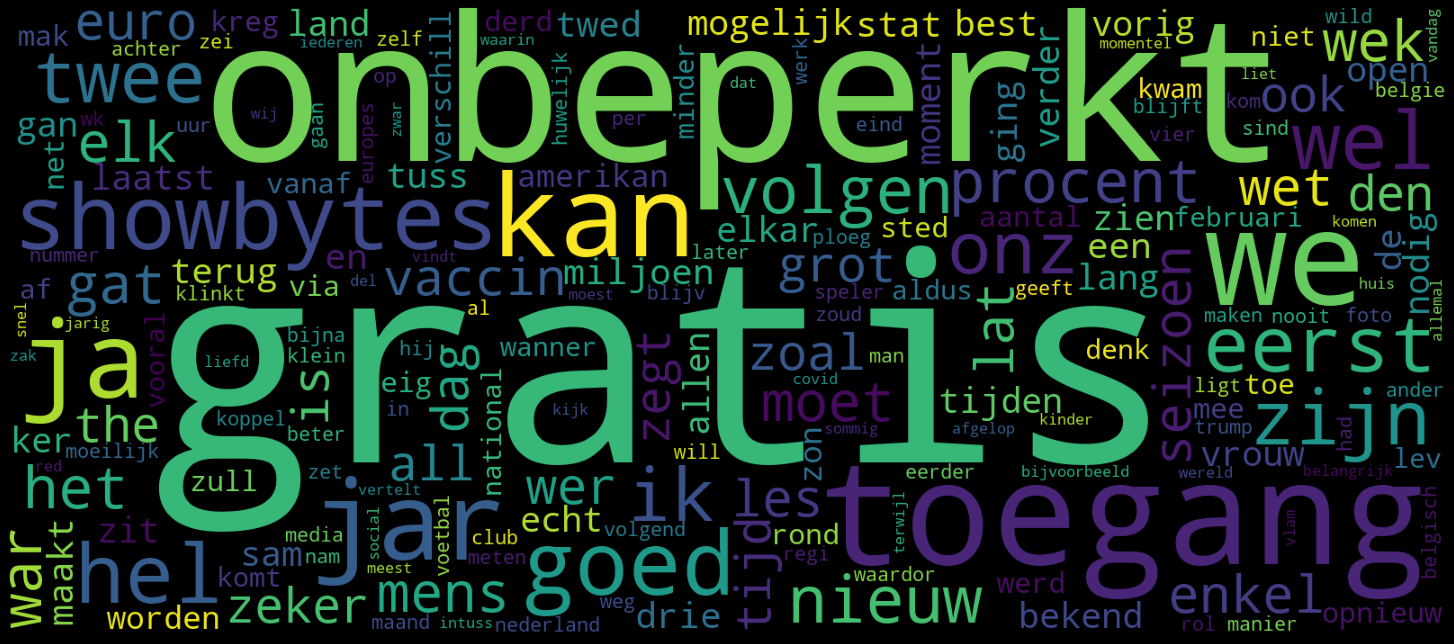

In [58]:
wordcloud = WordCloud(width=1600, height=700).generate_from_frequencies(frequency_dist)
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Topic Modelling

In [59]:
countVectorizer = CountVectorizer()
termFrequency = countVectorizer.fit_transform(df.complete_article)
featureNames = countVectorizer.get_feature_names()

In [60]:
lda = LatentDirichletAllocation(n_components=3, max_iter=10)
lda.fit(termFrequency)

LatentDirichletAllocation(n_components=3)

In [61]:
nmf = NMF(n_components=3)
data_nmf = nmf.fit_transform(termFrequency) 

In [62]:
lsi = TruncatedSVD(n_components=3)
data_lsi = lsi.fit_transform(termFrequency)

In [63]:
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [64]:
print("LDA Model:")
selected_topics(lda, countVectorizer)

LDA Model:
Topic 0:
[('we', 144.0642407008525), ('gratis', 129.92654454403294), ('onbeperkt', 128.9431046096036), ('toegang', 128.94310460958764), ('goed', 94.49712876638176), ('kan', 82.8088251660714), ('jar', 75.87434636501615), ('ja', 68.93113097034116), ('wel', 67.63659479844686), ('vaccin', 65.33327844132764)]
Topic 1:
[('gratis', 135.50312915595296), ('toegang', 134.5185414367424), ('onbeperkt', 134.51854143672762), ('we', 113.62077738409332), ('jar', 91.58791771665723), ('kan', 77.29437618695842), ('ja', 69.38080618944797), ('showbytes', 67.42621893837565), ('elk', 53.8913049457671), ('eerst', 51.400340471664336)]
Topic 2:
[('gratis', 80.5703263000038), ('toegang', 77.53835395365967), ('onbeperkt', 77.53835395365842), ('procent', 50.38045075508054), ('kan', 43.89679864695987), ('ja', 40.68806284020047), ('showbytes', 38.93536319780885), ('goed', 35.899337186463065), ('wel', 33.671325483887344), ('we', 33.314981915043816)]


In [65]:
print("NMF Model:")
selected_topics(nmf, countVectorizer)

NMF Model:
Topic 0:
[('gratis', 2.6563094590933765), ('onbeperkt', 2.598378161748969), ('toegang', 2.598378161748969), ('goed', 1.792249967783013), ('kan', 1.703957745017148), ('wel', 1.637222992323969), ('ja', 1.396937732431022), ('jar', 1.3283950770282236), ('showbytes', 1.2991890808744846), ('ik', 1.2393165755873221)]
Topic 1:
[('procent', 3.1757513067695413), ('vaccin', 2.5570636443649635), ('johnson', 1.068823468294229), ('we', 1.056931670973325), ('volgen', 0.9688087523751888), ('coronavaccin', 0.8246760969871288), ('lat', 0.7769086331802019), ('moet', 0.7503581018346221), ('onbeperkt', 0.6947850525535253), ('toegang', 0.6947850525535253)]
Topic 2:
[('we', 4.073946895564843), ('elk', 2.3344548366126165), ('jar', 2.112117984060009), ('onz', 1.3768168830599923), ('regi', 1.3507344147655735), ('liefd', 1.2337815238740877), ('elkar', 1.210956041000288), ('twee', 1.1970186847872792), ('koppel', 1.073479081347259), ('huwelijk', 1.056708390056456)]


## Text Summarization

In [66]:
data = pd.read_csv('hln.csv')
data.head()

,category,title,article_intro,article_body
0,Nieuws,LIVE. Frankrijk sluit de grenzen voor niet-ess...,Het wetenschappelijk comité van het Europees G...,"• Geen toffe vooruitzichten, wel onzekerheid: ..."
1,Internet,Toezichtsraad Facebook vindt “verwijderbeleid”...,Een toezichtsraad van de sociale mediagigant F...,De raad geldt als een onafhankelijk controleli...
2,Buitenland,Black Lives Matter-beweging genomineerd voor N...,De Black Lives Matter-beweging is dit jaar gen...,Eide is van mening dat dat BLM-beweging landen...
3,Belgisch Voetbal,Onze Antwerp-watcher over Lamkel Zé: “No way d...,AntwerpZe gaan hem houden. Maandag sluit de wi...,Gratis onbeperkt toegang tot Showbytes? Dat ka...
4,Jupiler Pro League,Lamkel Zé met twee goals belangrijk voor Antwe...,Jupiler Pro LeagueAntwerp heeft met de nodige ...,De thuisploeg nam meteen het initiatief tegen ...


In [67]:
data.article_body = data.article_body.replace(np.nan, '')
data['complete_article'] = data['title'].str.cat(df[['article_intro', 'article_body']], sep=' ')
data.head()

,category,title,article_intro,article_body,complete_article
0,Nieuws,LIVE. Frankrijk sluit de grenzen voor niet-ess...,Het wetenschappelijk comité van het Europees G...,"• Geen toffe vooruitzichten, wel onzekerheid: ...",LIVE. Frankrijk sluit de grenzen voor niet-ess...
1,Internet,Toezichtsraad Facebook vindt “verwijderbeleid”...,Een toezichtsraad van de sociale mediagigant F...,De raad geldt als een onafhankelijk controleli...,Toezichtsraad Facebook vindt “verwijderbeleid”...
2,Buitenland,Black Lives Matter-beweging genomineerd voor N...,De Black Lives Matter-beweging is dit jaar gen...,Eide is van mening dat dat BLM-beweging landen...,Black Lives Matter-beweging genomineerd voor N...
3,Belgisch Voetbal,Onze Antwerp-watcher over Lamkel Zé: “No way d...,AntwerpZe gaan hem houden. Maandag sluit de wi...,Gratis onbeperkt toegang tot Showbytes? Dat ka...,Onze Antwerp-watcher over Lamkel Zé: “No way d...
4,Jupiler Pro League,Lamkel Zé met twee goals belangrijk voor Antwe...,Jupiler Pro LeagueAntwerp heeft met de nodige ...,De thuisploeg nam meteen het initiatief tegen ...,Lamkel Zé met twee goals belangrijk voor Antwe...


In [68]:
def clean_text(text):
    text = "".join(i for i in text if ord(i) < 128) #remove non-ascii characters
    return text

In [69]:
data['complete_article'] = data['complete_article'].apply(clean_text)

In [70]:
from summa.summarizer import summarize

In [71]:
def summarizer(text):
    summary = summarize(text)
    if len(summary) == 0:
        return text
    else:
        return summary

In [72]:
data['summary'] = data.complete_article.apply(summarizer)

In [73]:
data.summary

0      Het is het derde vaccin tegen Covid-19 zijn da...
1      Toezichtsraad Facebook vindt verwijderbeleid f...
2      Eide is van mening dat dat BLM-beweging landen...
3      Onze Antwerp-watcher over Lamkel Z: No way dat...
4      Lamkel Z met twee goals belangrijk voor Antwer...
                             ...                        
165    Huisdieren zijn het ultieme knuffelcontact: de...
166    Hoe een slimme weegschaal je kan helpen om fit...
167    Regenachtige en zachte vrijdag, kouder weekend...
168    Hij en zijn vrouw Kristien krijgen binnenkort ...
169    Na zijn abrupte vertrek uit de cast van Shotgu...
Name: summary, Length: 170, dtype: object

In [74]:
data.to_csv('hln_summarization.csv', index=False)

## Sentiment Analysis

In [75]:
import joblib
import pickle

In [76]:
vectorizer = pickle.load(open("vectorizer.pickle", "rb"))

In [77]:
articles_features = vectorizer.transform(df.complete_article)

In [78]:
# load the model from disk
filename = 'finalized_model.sav'
loaded_model = joblib.load(filename)
result = loaded_model.predict(articles_features)

In [79]:
result

array([0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 0,
       0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0,
       0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 0,
       0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2])

In [80]:
df["pred_sentiment"] = result

In [83]:
labels = {
    0: 'negative',
    1: 'neutral',
    2: 'positive',
}
for key, val in labels.items():
    df["pred_sentiment"] = df["pred_sentiment"].replace(key, val)

df["pred_sentiment"].head()

0    negative
1    positive
2    negative
3    positive
4    positive
Name: pred_sentiment, dtype: object

<AxesSubplot:>

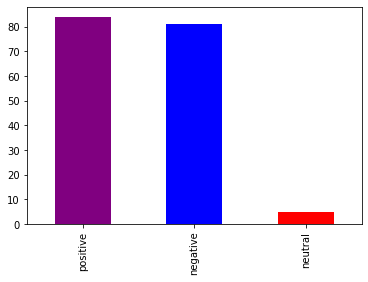

In [84]:
df.pred_sentiment.value_counts().plot.bar(color=['purple', 'blue', 'red'])

In [85]:
df.to_csv('hln_predicted_sentiment.csv', index=True)